# Initialization

## Packages

In [1]:
import datetime, os
import numpy as np
import pandas as pd
import io
import matplotlib
import matplotlib.pyplot as plt
import random
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from keras.models import Model
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

np.random.seed(7)

In [2]:
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
DATA_DIR = os.path.join(MOUNTPOINT, 'MyDrive/Membership_Inference/Data')
MODEL_DIR = os.path.join(MOUNTPOINT, 'MyDrive/Membership_Inference/Models')
SAVED_MODEL = os.path.join(MOUNTPOINT, 'MyDrive/Membership_Inference/Models_trained')
drive.mount(MOUNTPOINT)

Mounted at /content/gdrive


In [3]:
%load_ext tensorboard
log_dir=os.path.join(MODEL_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Pipeline

In [4]:
def windowed_dataset(series, window_size):
  """Chunks the series to small windows of size:window_size
  and shuffles the dataset"""
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=None, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  return dataset

In [5]:
def sequence_preprocessing(data, Id_column,x_column, y_column, window_size):
  """Groups vessels by ID and uses sliding windows to create the dataset
  From shape: (N_samples, features)
  to shape: (N_entries(=Number of windows), window_size, features)"""
  
  #Groups data by ID
  vessels = data.groupby(Id_column)

  for key, group in vessels:
    if(int(group.shape[0]) <= window_size):
      data.drop(data[data[Id_column] == key].index, inplace=True)
  vessels = data.groupby(Id_column)

  vessels_list = []

  #Split each vessel's trajectory into windows
  for _,vessel in vessels:
    vessel_temp = vessel.to_numpy()[:,x_column:y_column].astype('float64')
    windowed_vessel = windowed_dataset(vessel_temp, window_size)
    vessels_list.append(windowed_vessel)

  #Concat
  vessels_list = [[window for window in vessel] for vessel in vessels_list]
  vessels_window = tf.concat(vessels_list, axis=0)

  return vessels_window

# Data

In [6]:
TRAIN_DIR = 'AIS_2017_05_11.csv'
TEST_DIR = 'AIS_2017_02_19.csv'

window_size = 10
n_in = window_size

id_column = "MMSI"
first_column = 1
last_column = 9

## Train

In [7]:
train_path=os.path.join(DATA_DIR, TRAIN_DIR)
train_data = pd.read_csv(train_path, delimiter=",")
train_data.drop(['BaseDateTime', 'VesselName', 'IMO', 'CallSign', 'Status', 'Draft', 'Cargo'], axis=1, inplace=True)
train_data.dropna(subset = ['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'VesselType', 'Length', 'Width'], inplace=True)
train_data = train_data[['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'Length', 'Width', 'VesselType']]
train_data.head()

,MMSI,LAT,LON,SOG,COG,Heading,Length,Width,VesselType
6,367434580,38.22474,-85.84478,0.1,304.8,33.0,41.54,13.40,1025.0
7,367386870,29.35140,-94.75584,0.1,7.5,228.0,39.02,10.98,1025.0
9,367015880,40.64201,-74.12112,0.0,0.0,511.0,16.98,6.70,1025.0
11,366992110,33.73181,-78.56338,4.8,185.3,511.0,50.78,11.60,1012.0
12,367665480,37.00671,-88.25154,0.0,287.9,511.0,24.02,9.40,1025.0


In [8]:
print("types of ships: ", train_data["VesselType"].unique())
print("\nNumber of ships in the dataset are :", len(train_data["MMSI"].unique()))
train_ships = train_data["MMSI"].unique()
print("\nShape :", train_data.shape)

types of ships:  [1025. 1012. 1018. 1004. 1010.   52. 1024. 1005. 1019. 1001.   31.   30.
   99.   50.   72. 1014.   90. 1007.   20.   70. 1002. 1020. 1013.   37.
   33.   32. 1022.    0. 1011.   79. 1006. 1023.   35.   69.   36.   60.
   25. 1003.   80.   40.   15.   16.   34.   53.   57.   51.   71.   23.
   63.   82.   39.   89.   10.    9. 1017.   73.   95.   29.]

Number of ships in the dataset are : 9394

Shape : (6164433, 9)


In [9]:
train_data = train_data.head(1500000)

In [10]:
train_data = train_data[train_data.VesselType != 0]
train_data.VesselType.replace({30.0: 0, 31.0: 1, 36.0: 2, 37.0: 3, 
                               50.0: 4, 52.0: 5, 60.0: 6, 70.0: 7,
                               80.0: 8, 90.0: 9}, inplace=True)
train_data.drop(train_data[train_data.VesselType > 9].index, inplace=True)
train_data.VesselType.value_counts()

1.0    17609
5.0    12093
0.0     8117
4.0     5554
9.0     5543
7.0     4341
3.0     2952
6.0     2095
8.0      474
2.0      406
Name: VesselType, dtype: int64

In [11]:
tf_train_data = sequence_preprocessing(train_data, id_column, first_column, last_column, window_size)

In [12]:
train = tf_train_data
X_train = train[:, :, 0:7]
y_train = train[:, :, 7]
y_train = y_train[:, 1]

print(X_train.shape)
print(y_train.shape)

(5804, 10, 7)
(5804,)


## Test

In [13]:
test_path=os.path.join(DATA_DIR, TEST_DIR)
test_data = pd.read_csv(test_path, delimiter=",")
test_data.drop(['BaseDateTime', 'VesselName', 'IMO', 'CallSign', 'Status', 'Draft', 'Cargo',], axis=1, inplace=True)
test_data.dropna(subset = ['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'VesselType', 'Length', 'Width'], inplace=True)
test_data = test_data[['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'Length', 'Width', 'VesselType']]
test_data.head()

,MMSI,LAT,LON,SOG,COG,Heading,Length,Width,VesselType
0,220206000,33.71482,-118.49144,11.6,299.9,294.0,352.60,42.8,1004.0
1,636092195,28.30638,-80.11203,12.7,276.9,274.0,184.97,23.7,1004.0
3,367495210,29.76421,-91.76980,5.9,108.4,98.0,21.64,9.1,1025.0
4,367397950,37.92329,-87.62013,3.1,11.3,13.0,47.85,14.6,1025.0
5,367009460,29.92687,-90.19934,0.0,257.5,511.0,15.79,6.7,1025.0


In [14]:
print("types of ships: ", test_data["VesselType"].unique())
print("\nNumber of ships in the dataset are :", len(test_data["MMSI"].unique()))
test_ships = test_data["MMSI"].unique()
print("\nShape :", test_data.shape)

types of ships:  [1004. 1025. 1010.   30. 1024. 1012. 1001. 1005.   37. 1019.   70. 1018.
   63.   31.   50.   52.   32. 1002. 1011. 1007.   40. 1020. 1013.    0.
   33.   90. 1023.   79.   34.   36.   80.   72. 1014.   16. 1003.   69.
   57.   51.   73.   99.   60. 1022.   25.   81.   53.   20. 1006.    9.
 1017.   23.   71.   10.   83.   35.   89.   39.   19.]

Number of ships in the dataset are : 8057

Shape : (5385907, 9)


In [15]:
test_data = test_data.head(500000)

In [16]:
test_data = test_data[test_data.VesselType != 0]
test_data.VesselType.replace({30.0: 0, 31.0: 1, 36.0: 2, 37.0: 3, 
                              50.0: 4, 52.0: 5, 60.0: 6, 70.0: 7,
                              80.0: 8, 90.0: 9}, inplace=True)
test_data.drop(test_data[test_data.VesselType > 9].index, inplace=True)
test_data.VesselType.value_counts()

1.0    6864
5.0    4054
0.0    2191
9.0    1794
4.0    1571
7.0    1504
3.0     921
6.0     733
8.0     226
2.0     154
Name: VesselType, dtype: int64

In [17]:
tf_test_data = sequence_preprocessing(test_data, id_column, first_column, last_column, window_size)

In [18]:
test = tf_test_data
X_test = test[:, :, 0:7]
y_test = test[:, :, 7]
y_test = y_test[:, 1]

print(X_test.shape)
print(y_test.shape)

(1900, 10, 7)
(1900,)


## Comparison Ships

The goal is to establish an attack model which can identify the unique ships used for training the target model

In [19]:
print(train_ships)

[367434580 367386870 367015880 ... 440160000 368700000 367211000]


In [20]:
matching = list(set(train_ships).intersection(test_ships))
print(len(train_ships))
print(len(test_ships))
print(len(matching))

9394
8057
5691


# LSTM


## Architecture

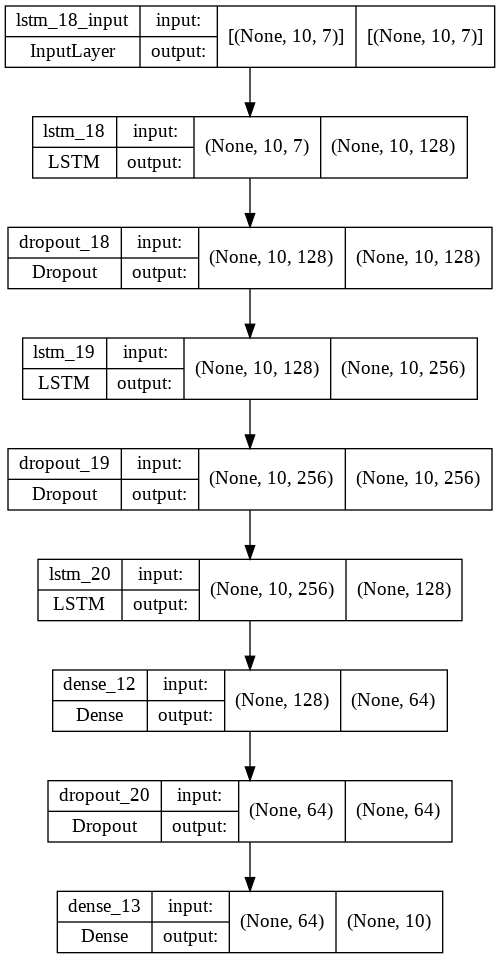

In [ ]:
model = Sequential()

model.add(LSTM(128, input_shape=(X_train.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

plot_model(model, show_shapes=True, to_file='ShadowModel2.png')

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 128)           69632     
                                                                 
 dropout_18 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_19 (LSTM)              (None, 10, 256)           394240    
                                                                 
 dropout_19 (Dropout)        (None, 10, 256)           0         
                                                                 
 lstm_20 (LSTM)              (None, 128)               197120    
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_20 (Dropout)        (None, 64)               

## Training

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'] )

model.fit(X_train, y_train, epochs=50, callbacks = [tensorboard_callback])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


182/182 [==============================] - 9s 18ms/step - loss: 1.6136 - accuracy: 0.4033
Epoch 2/50
182/182 [==============================] - 3s 18ms/step - loss: 1.3969 - accuracy: 0.4826
Epoch 3/50
182/182 [==============================] - 3s 18ms/step - loss: 1.3137 - accuracy: 0.5186
Epoch 4/50
182/182 [==============================] - 3s 18ms/step - loss: 1.2629 - accuracy: 0.5364
Epoch 5/50
182/182 [==============================] - 3s 19ms/step - loss: 1.1879 - accuracy: 0.5522
Epoch 6/50
182/182 [==============================] - 3s 19ms/step - loss: 1.1511 - accuracy: 0.5722
Epoch 7/50
182/182 [==============================] - 3s 19ms/step - loss: 1.0453 - accuracy: 0.6137
Epoch 8/50
182/182 [==============================] - 3s 19ms/step - loss: 1.0334 - accuracy: 0.6134
Epoch 9/50
182/182 [==============================] - 3s 18ms/step - loss: 0.9870 - accuracy: 0.6334
Epoch 10/50
182/182 [==============================] - 3s 18ms/step - loss: 0.9132 - accuracy: 0.6551


In [21]:
# model = tf.keras.models.load_model(os.path.join(SAVED_MODEL,"ShadowModel2.h5"))

In [ ]:
model.save(os.path.join(SAVED_MODEL, "ShadowModel2.h5"))

In [ ]:
!tensorboard dev upload --logdir $log_dir. \
  --name "ShadowModel2" \
  --description "{win=100,shift=None,opt=Adam,loss=SCE}encoder:LSTM(64,relu)" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Q9d5wW2URWGUG1NkYjFnJA/

[2022-03-20T16:28:44] Started scanning logdir.
E0320 16:28:50.133924 140258590529408 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0320 16:28:51.520348 140258590529408 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0320 16:29:07.404216 140258590529408 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0320 16:29:08.931521 140258590529408 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0320 16:29:09.592929 140258590529408 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0320 16:29:11.345897 140258590529408 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
[2022-03-20T16:29:13] Total uploaded: 740 scalars, 4475 tensors (3.1 MB), 10 binary objects (5.1 MB)
Total skipped: 6 binary objects (2.9 MB)
[2022-03-20T16:29:13] Done scanning logdir.


Done. View your TensorBo

## Evaluation

In [22]:
train_loss, train_acc = model.evaluate(X_train, y_train)
print('\nTrain accuracy:', train_acc)

182/182 [==============================] - 8s 8ms/step - loss: 0.1717 - accuracy: 0.9311

Train accuracy: 0.931082010269165


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', test_acc)

60/60 [==============================] - 0s 7ms/step - loss: 2.1437 - accuracy: 0.6274

Test accuracy: 0.6273684501647949


# 

In [23]:
y_test_pred = model.predict(X_test).argmax(axis=1)

# Confusion Matrix

Text(0.5, 1.0, 'Refined Confusion Matrix')

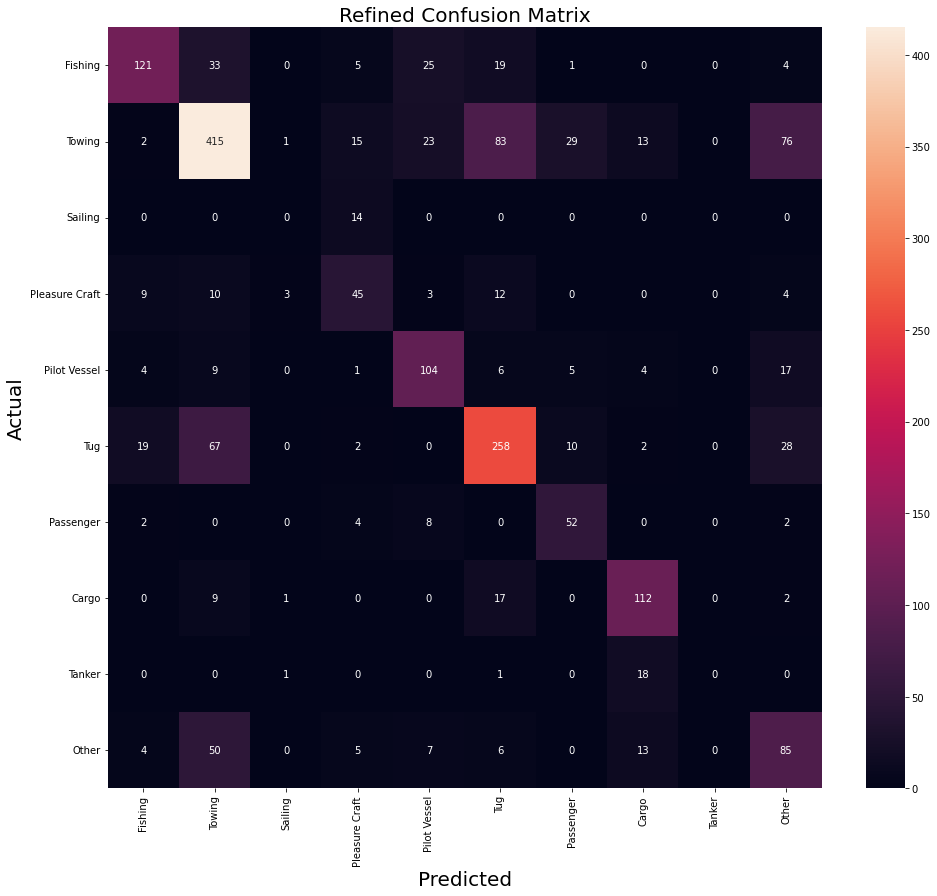

In [24]:
cf_matrix = confusion_matrix(y_test, y_test_pred)

labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
class_names = ['Fishing', 'Towing', 'Sailing', 'Pleasure Craft', 'Pilot Vessel', 'Tug', 'Passenger', 'Cargo', 'Tanker', 'Other']

fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax, fmt = 'g');

ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('Actual', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

# Black-box Behavior

In [25]:
IN_prediction = pd.DataFrame(model.predict(X_train))
IN_class = pd.DataFrame(y_train)
IN_label = pd.DataFrame(np.full(y_train.shape, 1))

OUT_prediction = pd.DataFrame(model.predict(X_test))
OUT_class = pd.DataFrame(y_test)
OUT_label = pd.DataFrame(np.full(y_test.shape, 0))

In [26]:
IN_prediction.insert(10, 'Class', IN_class)
IN_prediction.insert(11, 'Label', IN_label)
IN = IN_prediction

OUT_prediction.insert(10, 'Class', OUT_class)
OUT_prediction.insert(11, 'Label', OUT_label)
OUT = OUT_prediction

In [27]:
IN.to_csv("IN_ShadowModel2.csv")
OUT.to_csv("OUT_ShadowModel2.csv")